# NICE for calibration: Comparison against Temperature Scaling 

In [2]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt

from utils.data import get_cifar10, get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram
from calibrators import NiceCalibrator, TempScalingCalibrator

In [3]:
%matplotlib inline

In [4]:
cifar_dir = '../cifar-10'

## CNN trained on CIFAR3

Load dataset and precomputed logits:

In [5]:
models_dir = '../pretrained-models'
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))

# val/test split
random_split = np.random.permutation(3000)

val_target = target[random_split[:1500], :]
test_target = target[random_split[1500:], :]

val_logits = logits[random_split[:1500], :]
test_logits = logits[random_split[1500:], :]

### Evaluating misscalibration of the base model

Negative log-likelihood of the uncalibrated model on the validation set: 0.301
Expected calibration error of the uncalibrated model on the validation set: 0.03489


Negative log-likelihood of the uncalibrated model on the test set: 0.330
Expected calibration error of the uncalibrated model on the test set: 0.03683


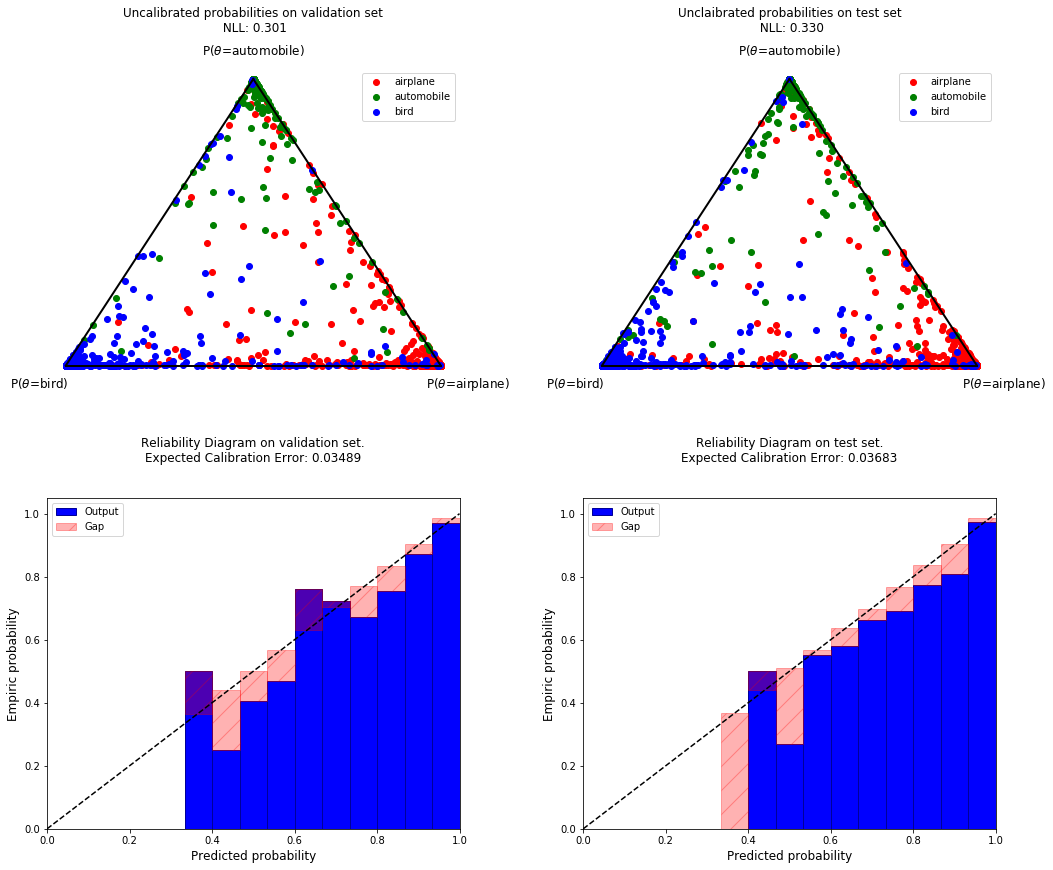

In [6]:
val_probs = softmax(val_logits, axis=1)
test_probs = softmax(test_logits, axis=1)

# Validation set
val_nll = neg_log_likelihood(val_probs, val_target)
val_ece = expected_calibration_error(val_probs, val_target, bins=15)

print('Negative log-likelihood of the uncalibrated model on the validation set: {:.3f}'.format(val_nll))
print('Expected calibration error of the uncalibrated model on the validation set: {:.5f}'.format(val_ece))

print('\n')

# Test set
test_nll = neg_log_likelihood(test_probs, test_target)
test_ece = expected_calibration_error(test_probs, test_target, bins=15)

print('Negative log-likelihood of the uncalibrated model on the test set: {:.3f}'.format(test_nll))
print('Expected calibration error of the uncalibrated model on the test set: {:.5f}'.format(test_ece))

fig, ax_arr = plt.subplots(2, 2, figsize=(17, 14), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0, 0] = plot_prob_simplex(val_probs, target=val_target, ax=ax_arr[0, 0],
                                 title='Uncalibrated probabilities on validation set\n NLL: {:.3f}'.format(val_nll),
                                 fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_prob_simplex(test_probs, target=test_target, ax=ax_arr[0, 1],
                                 title='Unclaibrated probabilities on test set\n NLL: {:.3f}'.format(test_nll),
                                 fontsize=12, labels=list(ix2label.values()));

ax_arr[1, 0] = reliability_diagram(val_probs, val_target, ax=ax_arr[1, 0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece), bins=15)
ax_arr[1, 1] = reliability_diagram(test_probs, test_target, ax=ax_arr[1, 1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece), bins=15)

plt.show()

### Calibrating with Temp-Scaling:

In [7]:
temp_scaling_cal = TempScalingCalibrator(val_logits, val_target)
print("Calibrated using temperature T={:.3f}".format(temp_scaling_cal.T))

Calibrated using temperature T=1.302


Negative log-likelihood on the validation set after temp-scaling calibration: 0.290
Expected calibration error on the validation set after temp-scaling calibration: 0.01873


Negative log-likelihood on the test set after temp-scaling calibration: 0.318
Expected calibration error on the test set after temp-scaling calibration: 0.01904


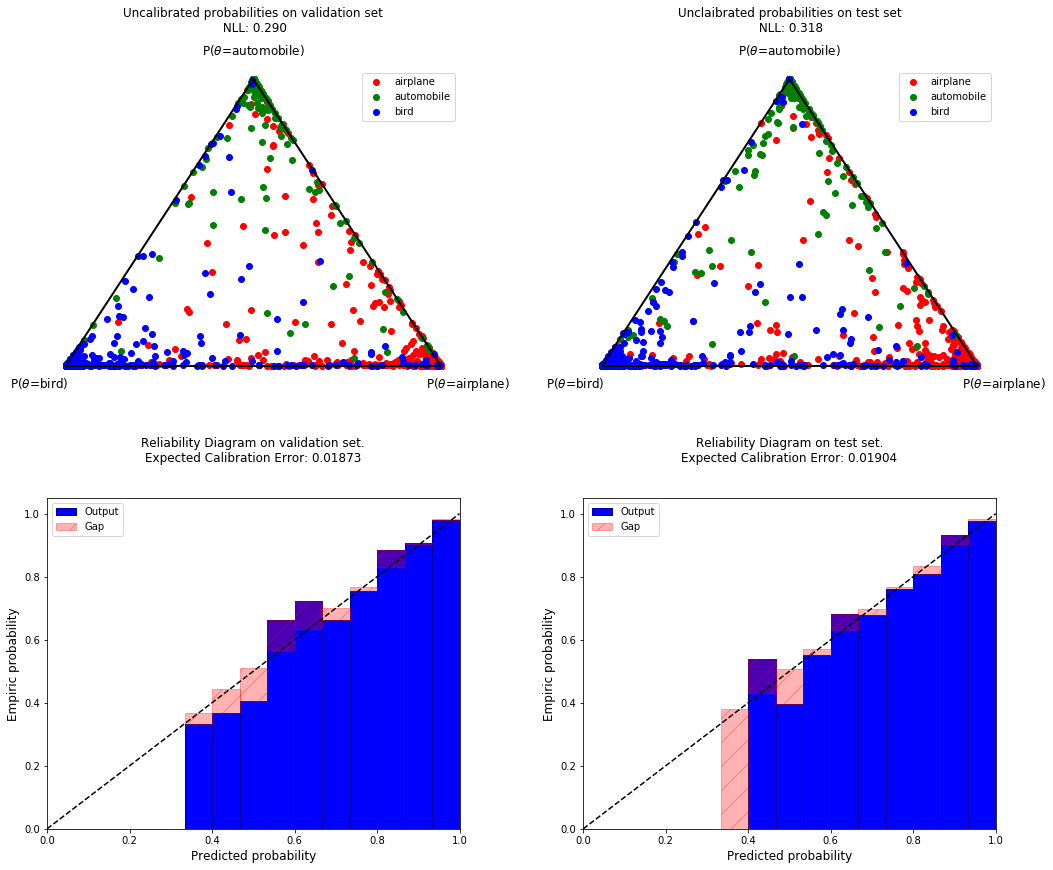

In [8]:
val_probs_temp = temp_scaling_cal.predict(val_logits)
test_probs_temp = temp_scaling_cal.predict(test_logits)

# Validation set
val_nll_temp = neg_log_likelihood(val_probs_temp, val_target)
val_ece_temp = expected_calibration_error(val_probs_temp, val_target, bins=15)

print('Negative log-likelihood on the validation set after temp-scaling calibration: {:.3f}'.format(val_nll_temp))
print('Expected calibration error on the validation set after temp-scaling calibration: {:.5f}'.format(val_ece_temp))

print('\n')

# Test set
test_nll_temp = neg_log_likelihood(test_probs_temp, test_target)
test_ece_temp = expected_calibration_error(test_probs_temp, test_target, bins=15)

print('Negative log-likelihood on the test set after temp-scaling calibration: {:.3f}'.format(test_nll_temp))
print('Expected calibration error on the test set after temp-scaling calibration: {:.5f}'.format(test_ece_temp))

fig, ax_arr = plt.subplots(2, 2, figsize=(17, 14), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0, 0] = plot_prob_simplex(val_probs, target=val_target, ax=ax_arr[0, 0],
                                 title='Uncalibrated probabilities on validation set\n NLL: {:.3f}'.format(val_nll_temp),
                                 fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_prob_simplex(test_probs, target=test_target, ax=ax_arr[0, 1],
                                 title='Unclaibrated probabilities on test set\n NLL: {:.3f}'.format(test_nll_temp),
                                 fontsize=12, labels=list(ix2label.values()));

ax_arr[1, 0] = reliability_diagram(val_probs_temp, val_target, ax=ax_arr[1, 0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece_temp), bins=15)
ax_arr[1, 1] = reliability_diagram(test_probs_temp, test_target, ax=ax_arr[1, 1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece_temp), bins=15)
plt.show()

### Calibrating using NICE flow:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fitted in 250.383s


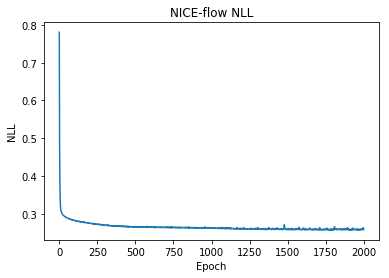

In [9]:
t0 = time.time()
nice_cal = NiceCalibrator(val_logits, val_target, layers=4, hidden_size=[4, 4],
                          version=2, epochs=2000, batch_size=50)
print('Fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

Negative log-likelihood on the validation set after NICE calibration: 0.257
Expected calibration error on the validation set after NICE calibration: 0.01128


Negative log-likelihood on the test set after NICE calibration: 0.331
Expected calibration error on the test set after NICE calibration: 0.02747


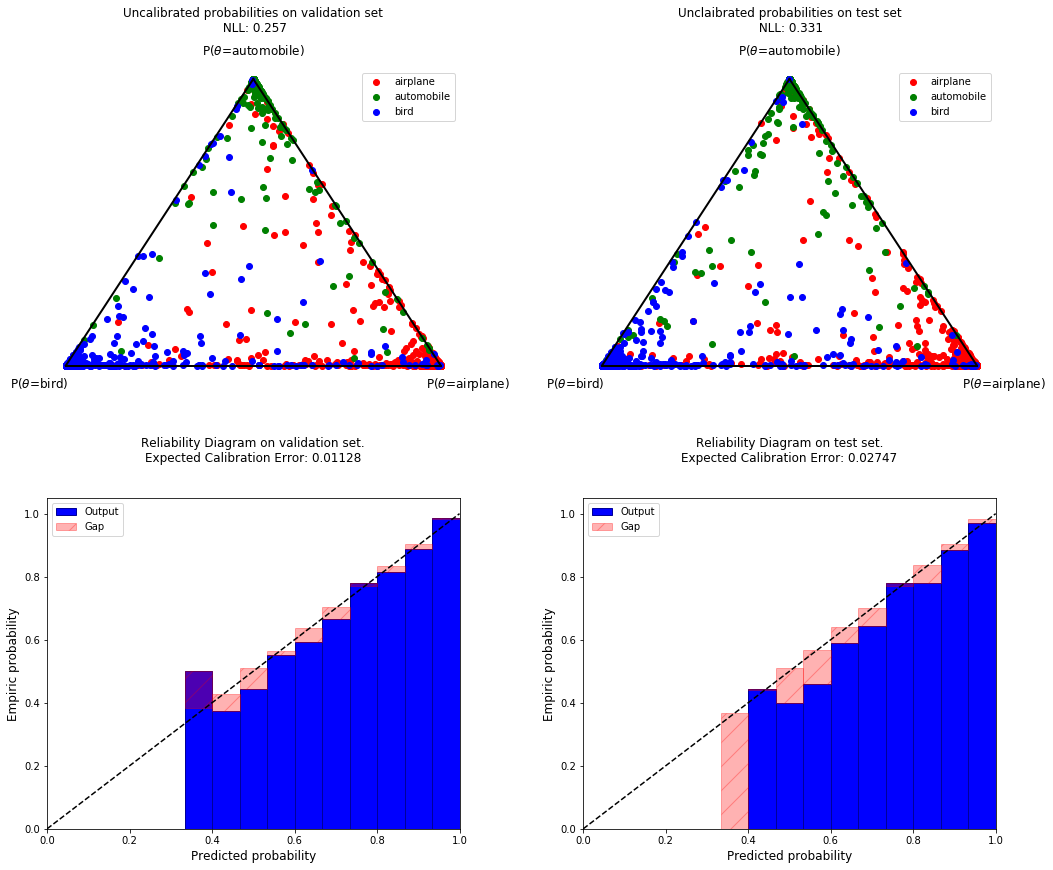

In [10]:
val_probs_nice = nice_cal.predict(val_logits)
test_probs_nice = nice_cal.predict(test_logits)

# Validation set
val_nll_nice = neg_log_likelihood(val_probs_nice, val_target)
val_ece_nice = expected_calibration_error(val_probs_nice, val_target, bins=15)

print('Negative log-likelihood on the validation set after NICE calibration: {:.3f}'.format(val_nll_nice))
print('Expected calibration error on the validation set after NICE calibration: {:.5f}'.format(val_ece_nice))

print('\n')

# Test set
test_nll_nice = neg_log_likelihood(test_probs_nice, test_target)
test_ece_nice = expected_calibration_error(test_probs_nice, test_target, bins=15)

print('Negative log-likelihood on the test set after NICE calibration: {:.3f}'.format(test_nll_nice))
print('Expected calibration error on the test set after NICE calibration: {:.5f}'.format(test_ece_nice))


fig, ax_arr = plt.subplots(2, 2, figsize=(17, 14), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0, 0] = plot_prob_simplex(val_probs, target=val_target, ax=ax_arr[0, 0],
                                 title='Uncalibrated probabilities on validation set\n NLL: {:.3f}'.format(val_nll_nice),
                                 fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_prob_simplex(test_probs, target=test_target, ax=ax_arr[0, 1],
                                 title='Unclaibrated probabilities on test set\n NLL: {:.3f}'.format(test_nll_nice),
                                 fontsize=12, labels=list(ix2label.values()));

ax_arr[1, 0] = reliability_diagram(val_probs_nice, val_target, ax=ax_arr[1, 0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece_nice), bins=15)
ax_arr[1, 1] = reliability_diagram(test_probs_nice, test_target, ax=ax_arr[1, 1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece_nice), bins=15)
plt.show()

### Calibration comparison:

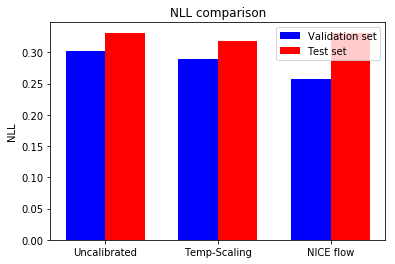

In [12]:
fig, ax = plt.subplots()

ind = np.arange(3)
width = 0.35

ticks = ['Uncalibrated', 'Temp-Scaling', 'NICE flow']

validation = np.array([val_nll, val_nll_temp, val_nll_nice])
test = np.array([test_nll, test_nll_temp, test_nll_nice])

rects1 = ax.bar(ind, validation, width, color='b', label='Validation set')
rects2 = ax.bar(ind+width, test, width, color='r', label='Test set')

ax.set_ylabel('NLL')
ax.set_title('NLL comparison')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(ticks)
ax.legend()

plt.show()

### Visualize decision regions on the simplex:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


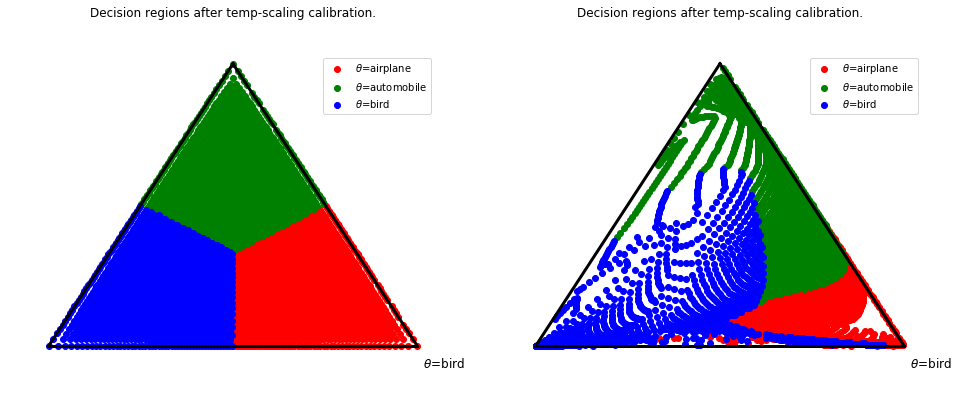

In [26]:
## Mesh of logits
indep_probs = np.array([np.array(tup) for tup in itertools.product(np.linspace(0, 1, num=100), repeat=2)])
indep_probs = indep_probs[np.where(np.sum(indep_probs, axis=1)<=1)]
gen_probs = np.hstack((indep_probs, 1.-np.sum(indep_probs, axis=1, keepdims=True)))
gen_logits = np.log(gen_probs)

target = np.argmax(gen_probs, axis=1)

# Calibrate mesh
temp_probs = temp_scaling_cal.predict(gen_logits)
nice_probs = nice_cal.predict(gen_logits)

### Create plot
fig, ax_arr = plt.subplots(1, 2, figsize=(16, 6))
colors = ['r', 'g', 'b']

# Temp-scaling
ax_arr[0].axis('off')
_, tax0 = ternary.figure(ax=ax_arr[0])

for t in range(3):
    tax0.scatter(temp_probs[np.where(target==t)], color=colors[t], label='$\\theta$={}'.format(ix2label[t]))

tax0.legend()
tax0.right_corner_label("$\\theta$={}".format(ix2label[0]), fontsize=12)
tax0.right_corner_label("$\\theta$={}".format(ix2label[1]), fontsize=12)
tax0.right_corner_label("$\\theta$={}".format(ix2label[2]), fontsize=12)
tax0.set_title('Decision regions after temp-scaling calibration.\n\n', fontsize=12)
tax0.boundary(linewidth=3.0)
ax_arr[0] = tax0

# NICE
ax_arr[1].axis('off')
_, tax1 = ternary.figure(ax=ax_arr[1])

for t in range(3):
    tax1.scatter(nice_probs[np.where(target==t)], color=colors[t], label='$\\theta$={}'.format(ix2label[t]))

tax1.legend()
tax1.right_corner_label("$\\theta$={}".format(ix2label[0]), fontsize=12)
tax1.right_corner_label("$\\theta$={}".format(ix2label[1]), fontsize=12)
tax1.right_corner_label("$\\theta$={}".format(ix2label[2]), fontsize=12)
tax1.set_title('Decision regions after temp-scaling calibration.\n\n', fontsize=12)
tax1.boundary(linewidth=3.0)
ax_arr[1] = tax1

plt.show();

### Load cifar10

In [4]:
cifar10, ix2label = get_cifar10(cifar_dir, test=True)

To compare the calibration capabilities of each method we are going to calibrate the model on a subset of the test set, and evaluate it on the other subset. Then compare results for each calibration method.

In [5]:
target = onehot_encode(cifar10['test_labels'])

# val/test split
random_split = np.random.permutation(10000)

val_target = target[random_split[:5000], :]
test_target = target[random_split[5000:], :]

### Load precomputed logits

In [6]:
model = 'resnet32_v1'
models_dir = '../pretrained-models'

In [7]:
_, logits = load_logits(os.path.join(models_dir, model))

# val/test split
val_logits = logits[random_split[:5000], :]
test_logits = logits[random_split[5000:], :]

## Calibrating the model

### Evaluating the uncalibrated model:
Negative Log-Likelihood and Expected Calibration Error on validation and test set

In [8]:
val_probs = softmax(val_logits, axis=1)
test_probs = softmax(test_logits, axis=1)

# Validation set
val_nll = neg_log_likelihood(val_probs, val_target)
val_ece = expected_calibration_error(val_probs, val_target, bins=15)

print('Negative log-likelihood of the uncalibrated model on the validation set: {:.3f}'.format(val_nll))
print('Expected calibration error of the uncalibrated model on the validation set: {:.5f}'.format(val_ece))

print('\n')

# Test set
test_nll = neg_log_likelihood(test_probs, test_target)
test_ece = expected_calibration_error(test_probs, test_target, bins=15)

print('Negative log-likelihood of the uncalibrated model on the test set: {:.3f}'.format(test_nll))
print('Expected calibration error of the uncalibrated model on the test set: {:.5f}'.format(test_ece))

Negative log-likelihood of the uncalibrated model on the validation set: 0.277
Expected calibration error of the uncalibrated model on the validation set: 0.03735


Negative log-likelihood of the uncalibrated model on the test set: 0.258
Expected calibration error of the uncalibrated model on the test set: 0.03405


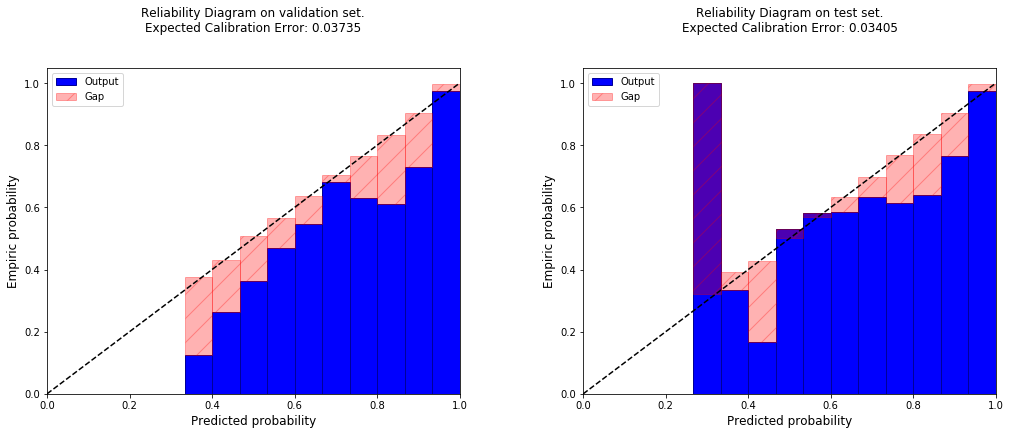

In [9]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

ax_arr[0] = reliability_diagram(val_probs, val_target, ax=ax_arr[0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece), bins=15)
ax_arr[1] = reliability_diagram(test_probs, test_target, ax=ax_arr[1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece), bins=15)
plt.show()

### Temperature Scaling calibration:

In [10]:
temp_scaling_cal = TempScalingCalibrator(val_logits, val_target)
print("Calibrated using temperature T={:.3f}".format(temp_scaling_cal.T))

Calibrated using temperature T=1.773


Evaluating calibration:

In [11]:
val_probs_temp = temp_scaling_cal.predict(val_logits)
test_probs_temp = temp_scaling_cal.predict(test_logits)

# Validation set
val_nll_temp = neg_log_likelihood(val_probs_temp, val_target)
val_ece_temp = expected_calibration_error(val_probs_temp, val_target, bins=15)

print('Negative log-likelihood on the validation set after temp-scaling calibration: {:.3f}'.format(val_nll_temp))
print('Expected calibration error on the validation set after temp-scaling calibration: {:.5f}'.format(val_ece_temp))

print('\n')

# Test set
test_nll_temp = neg_log_likelihood(test_probs_temp, test_target)
test_ece_temp = expected_calibration_error(test_probs_temp, test_target, bins=15)

print('Negative log-likelihood on the test set after temp-scaling calibration: {:.3f}'.format(test_nll_temp))
print('Expected calibration error on the test set after temp-scaling calibration: {:.5f}'.format(test_ece_temp))

Negative log-likelihood on the validation set after temp-scaling calibration: 0.226
Expected calibration error on the validation set after temp-scaling calibration: 0.00707


Negative log-likelihood on the test set after temp-scaling calibration: 0.216
Expected calibration error on the test set after temp-scaling calibration: 0.01085


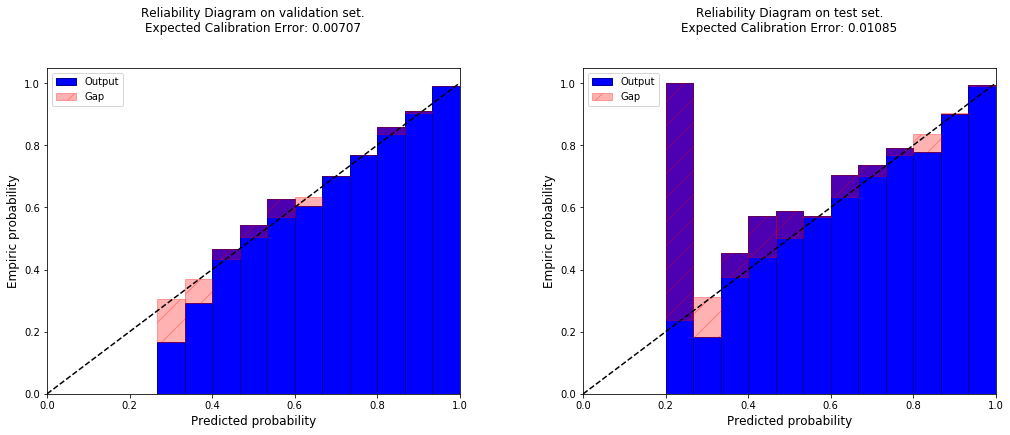

In [12]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

ax_arr[0] = reliability_diagram(val_probs_temp, val_target, ax=ax_arr[0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece_temp), bins=15)
ax_arr[1] = reliability_diagram(test_probs_temp, test_target, ax=ax_arr[1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece_temp), bins=15)
plt.show()

### NICE flow calibration:

In [13]:
nice_cal = NiceCalibrator(val_logits, val_target, layers=4, hidden_size=[10, 10])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Evaluating calibration:

In [14]:
val_probs_nice = nice_cal.predict(val_logits)
test_probs_nice = nice_cal.predict(test_logits)

# Validation set
val_nll_nice = neg_log_likelihood(val_probs_nice, val_target)
val_ece_nice = expected_calibration_error(val_probs_nice, val_target, bins=15)

print('Negative log-likelihood on the validation set after NICE calibration: {:.3f}'.format(val_nll_nice))
print('Expected calibration error on the validation set after NICE calibration: {:.5f}'.format(val_ece_nice))

print('\n')

# Test set
test_nll_nice = neg_log_likelihood(test_probs_nice, test_target)
test_ece_nice = expected_calibration_error(test_probs_nice, test_target, bins=15)

print('Negative log-likelihood on the test set after NICE calibration: {:.3f}'.format(test_nll_nice))
print('Expected calibration error on the test set after NICE calibration: {:.5f}'.format(test_ece_nice))

Negative log-likelihood on the validation set after NICE calibration: 0.092
Expected calibration error on the validation set after NICE calibration: 0.01619


Negative log-likelihood on the test set after NICE calibration: 0.509
Expected calibration error on the test set after NICE calibration: 0.06460


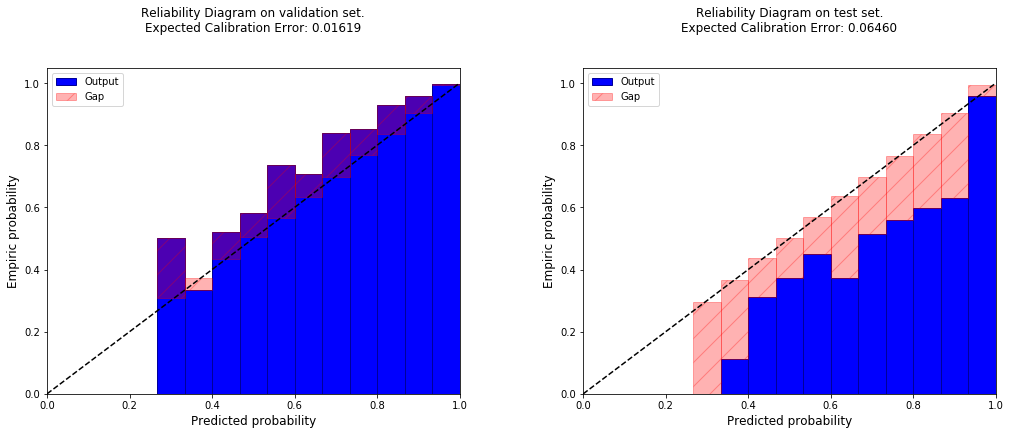

In [15]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

ax_arr[0] = reliability_diagram(val_probs_nice, val_target, ax=ax_arr[0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece_nice), bins=15)
ax_arr[1] = reliability_diagram(test_probs_nice, test_target, ax=ax_arr[1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece_nice), bins=15)

plt.show()

## CIFAR3

### Uncalibrated model: 

Negative log-likelihood of the uncalibrated model on the validation set: 0.327
Expected calibration error of the uncalibrated model on the validation set: 0.04228


Negative log-likelihood of the uncalibrated model on the test set: 0.305
Expected calibration error of the uncalibrated model on the test set: 0.02809


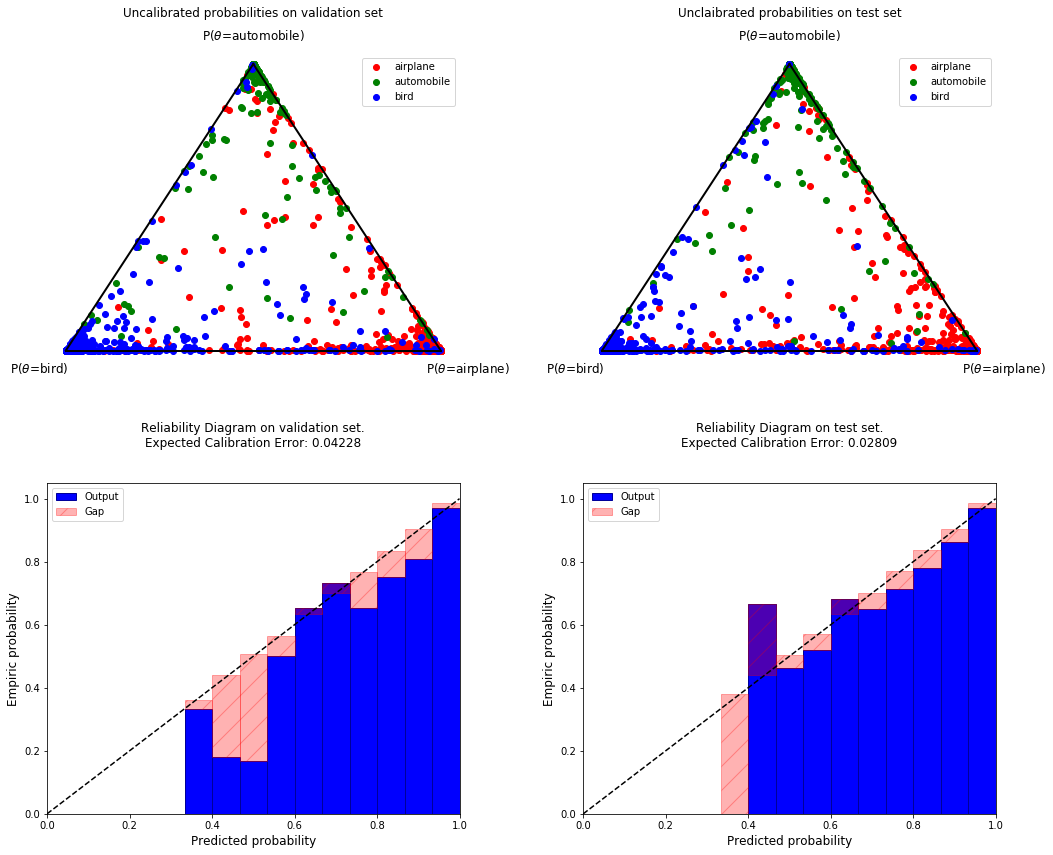

### Temperature scaling:

Calibrated using temperature T=1.352


Negative log-likelihood on the validation set after temp-scaling calibration: 0.312
Expected calibration error on the validation set after temp-scaling calibration: 0.01871


Negative log-likelihood on the test set after temp-scaling calibration: 0.297
Expected calibration error on the test set after temp-scaling calibration: 0.02468


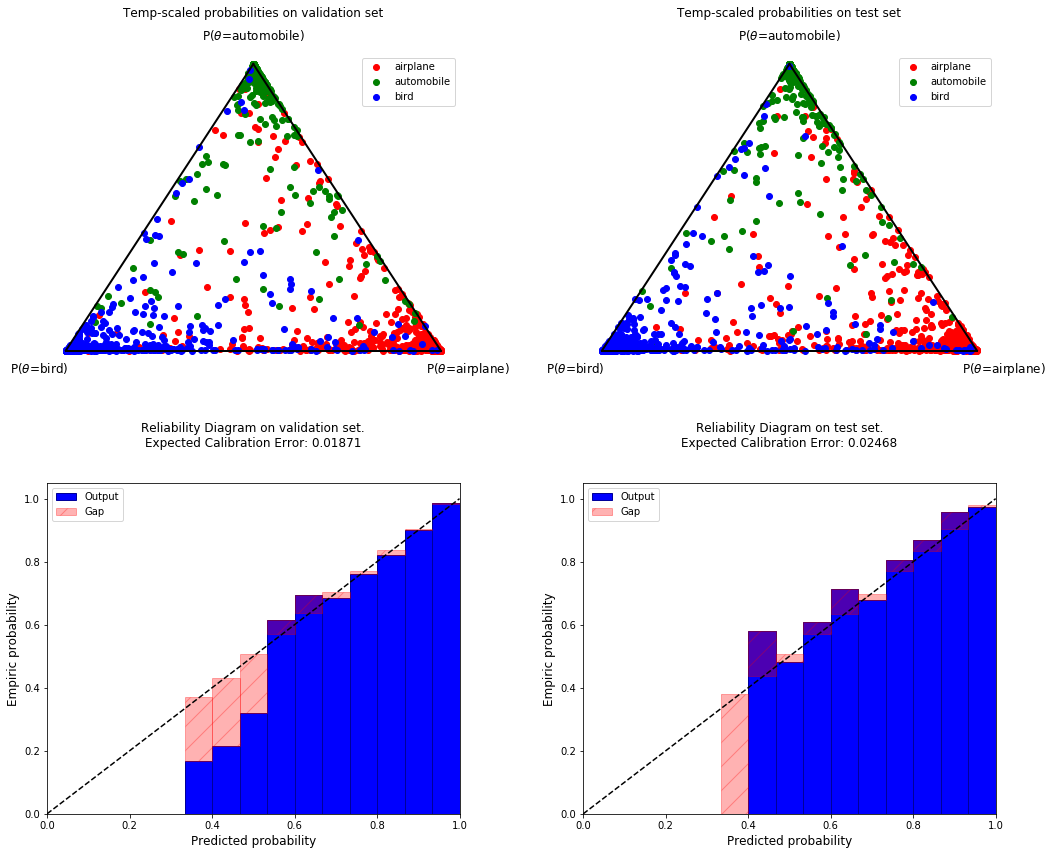

### NICE flow calibration: 

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Negative log-likelihood on the validation set after NICE calibration: 0.283
Expected calibration error on the validation set after NICE calibration: 0.01217


Negative log-likelihood on the test set after NICE calibration: 0.299
Expected calibration error on the test set after NICE calibration: 0.01640


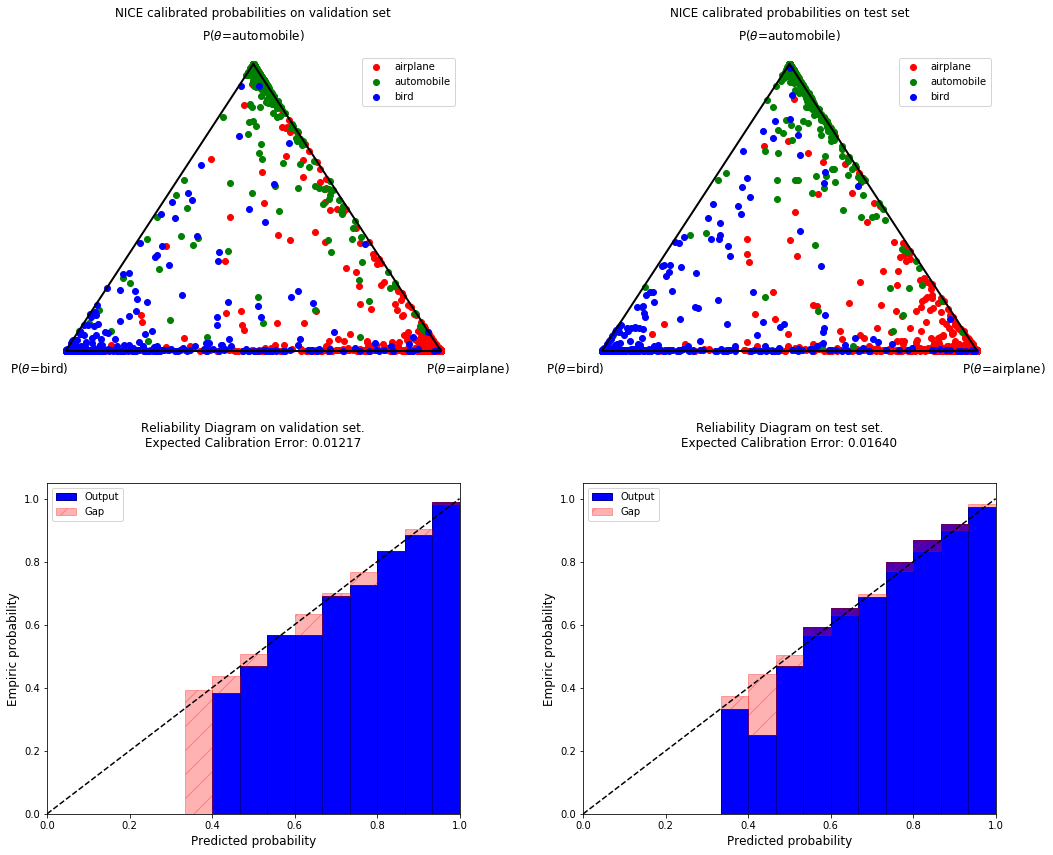